#### Import Toolkit

In [1]:
# Thêm thư viện
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model , Sequential
# from keras.layers.core import Dense
# from keras.layers.core import Dropout
# from keras.layers.core import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
import numpy as np
import random

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# root_dir = '/content/drive/MyDrive/5_AIADVANCE/GK_AI_Advance/'
root_dir = './Dataset/Dataset_102flower_TOP15'
# Đường dẫn tới thư mục con 'train', 'val' và 'test'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

In [3]:
img_size = (224 , 224) # resize về đúng kích thước mà VGG 16 cần là (224,224)
batch_size = 8
img_shape = (img_size[0] , img_size[1] , 3)

# làm giàu dữ liệu data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)  # Chỉ rescale cho dữ liệu kiểm tra
# làm giàu dữ liệu data augmentation

train_gen = train_datagen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = test_datagen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = test_datagen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 1748 images belonging to 15 classes.
Found 496 images belonging to 15 classes.
Found 265 images belonging to 15 classes.


##### Show Sample From Train Data

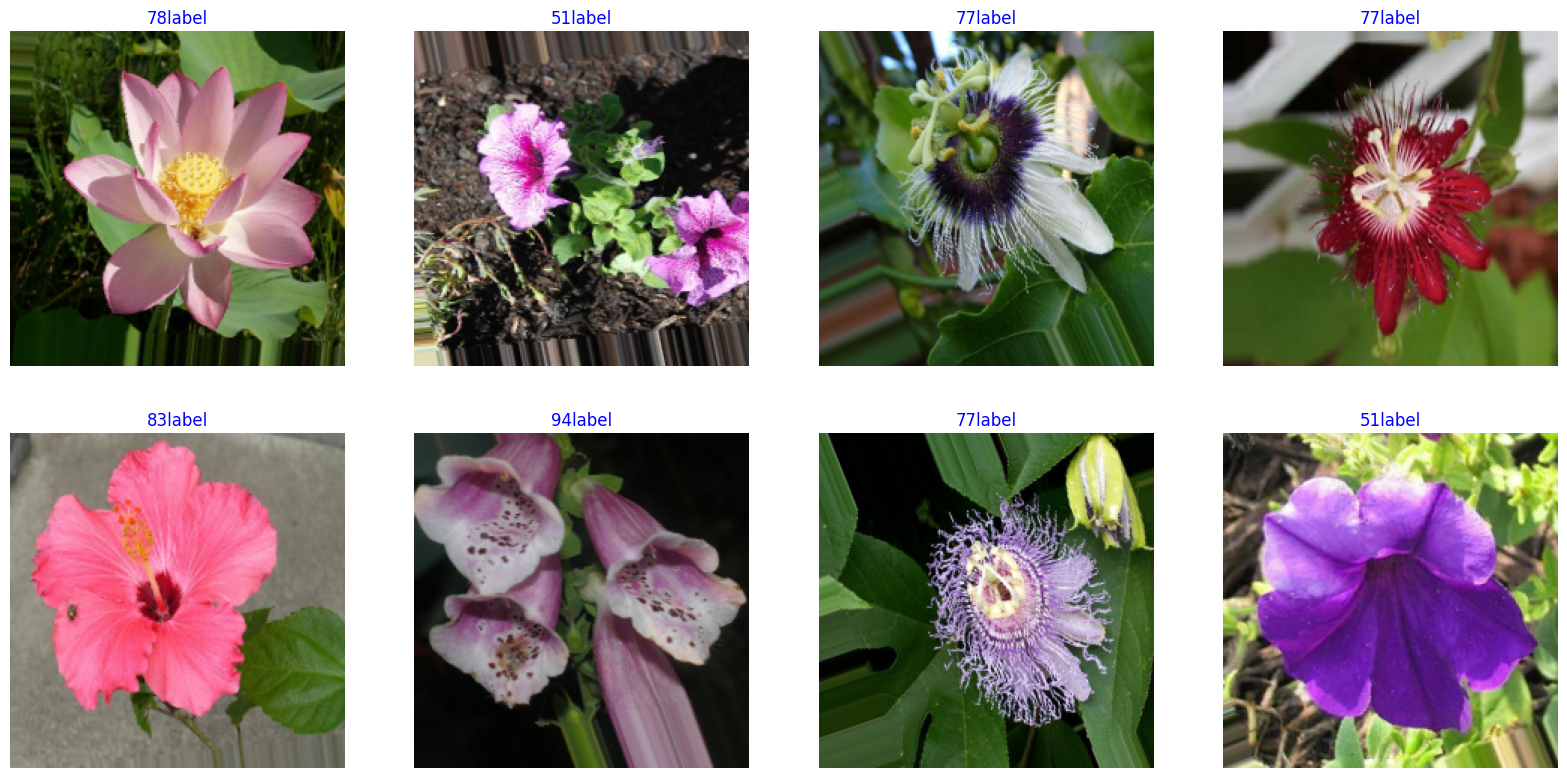

In [4]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] # Không cần chia lại cho 255
    plt.imshow(image)
    class_index = np.argmax(labels[i]) # Lấy index của nhãn cao nhất
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [9]:
# pre_train model : Là model được train sẵn trước đó , chính là VGG16,..
# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.
myConvNetModelVGG16 = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#### Lấy lớp cuối (xem như lớp output) của "Model VGG16 sau khi bỏ đi FC" rồi thêm các lớp của mình vào
# Xây thêm các layer
# Lấy output của ConvNet trong VGG16
myFCHead = myConvNetModelVGG16.output # (None, 7, 7, 512) 
myFCHead = Flatten(name='flatten')(myFCHead) # 7x7x512 = 25088
myFCHead = Dense(256, activation='relu')(myFCHead) # 256
myFCHead = Dense(128)(myFCHead)
# Output layer với softmax activation
myFCHead = Dense(len(classes), activation='softmax')(myFCHead) # len(classes) = 17 số nhãn cần nhận diện 


# Xây dựng model bằng việc nối ConvNet của VGG16 và fcHead
myModel = Model(inputs=myConvNetModelVGG16.input, outputs=myFCHead)

##### Model VGG16 gốc

In [10]:
model_vgg16 = VGG16(weights='imagenet')
model_vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

#### Model VGG16 bỏ đi FC 

In [11]:
myConvNetModelVGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Tạo ra Model mới bằng cácg nối ConvNet của VGG16 và fcHead

In [12]:
myModel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,141,841 (80.65 MB)

 Trainable params: 21,141,841 (80.65 MB)

 Non-trainable params: 0 (0.00 B)

#### Training 

In [13]:
# freeze VGG model
for layer in myConvNetModelVGG16.layers:
    layer.trainable = False

# thuật toán tối ưu 
# optimizer = tf.keras.optimizers.Adam()
optimizer = RMSprop(0.001) 
myModel.compile(optimizer, 'categorical_crossentropy', metrics=['accuracy'])

numOfEpoch = 10
H = myModel.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=valid_gen,
    validation_steps=len(valid_gen),
    epochs=numOfEpoch,
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 676ms/step - accuracy: 0.1375 - loss: 6.1194 - val_accuracy: 0.3199 - val_loss: 2.1032
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 79s 661ms/step - accuracy: 0.2454 - loss: 2.3674 - val_accuracy: 0.4228 - val_loss: 1.7078
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 76s 637ms/step - accuracy: 0.3574 - loss: 2.0112 - val_accuracy: 0.5919 - val_loss: 1.4448
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 75s 629ms/step - accuracy: 0.3922 - loss: 1.8659 - val_accuracy: 0.6397 - val_loss: 1.1918
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━

In [14]:
# unfreeze some last CNN layer:
for layer in myConvNetModelVGG16.layers[15:]:
    layer.trainable = True

save_best_only = True
checkpoint = ModelCheckpoint('models/myVGG16_model-{epoch:03d}.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=save_best_only,
                             mode='auto')

numOfEpoch = 20
optimizer = SGD(0.001)
myModel.compile(optimizer, 'categorical_crossentropy', metrics=['accuracy']) # ta có thể ghi optimizer = optimizer, hoặc optimizer là nó tự hiểu

H = myModel.fit(
    train_gen,
    steps_per_epoch = len(train_gen),
    validation_data = valid_gen,
    validation_steps = len(valid_gen),
    epochs=numOfEpoch,
    # callbacks=[checkpoint]
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 84s 695ms/step - accuracy: 0.5695 - loss: 1.3714 - val_accuracy: 0.7096 - val_loss: 0.9870
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 690ms/step - accuracy: 0.5609 - loss: 1.2664 - val_accuracy: 0.7684 - val_loss: 0.8925
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 83s 693ms/step - accuracy: 0.6284 - loss: 1.1328 - val_accuracy: 0.7316 - val_loss: 0.8121
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 83s 693ms/step - accuracy: 0.6543 - loss: 1.0374 - val_accuracy: 0.7831 - val_loss: 0.7082
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━

In [15]:
myModel.save('Model_VGG16_fine_tune.h5')

## Model Performance

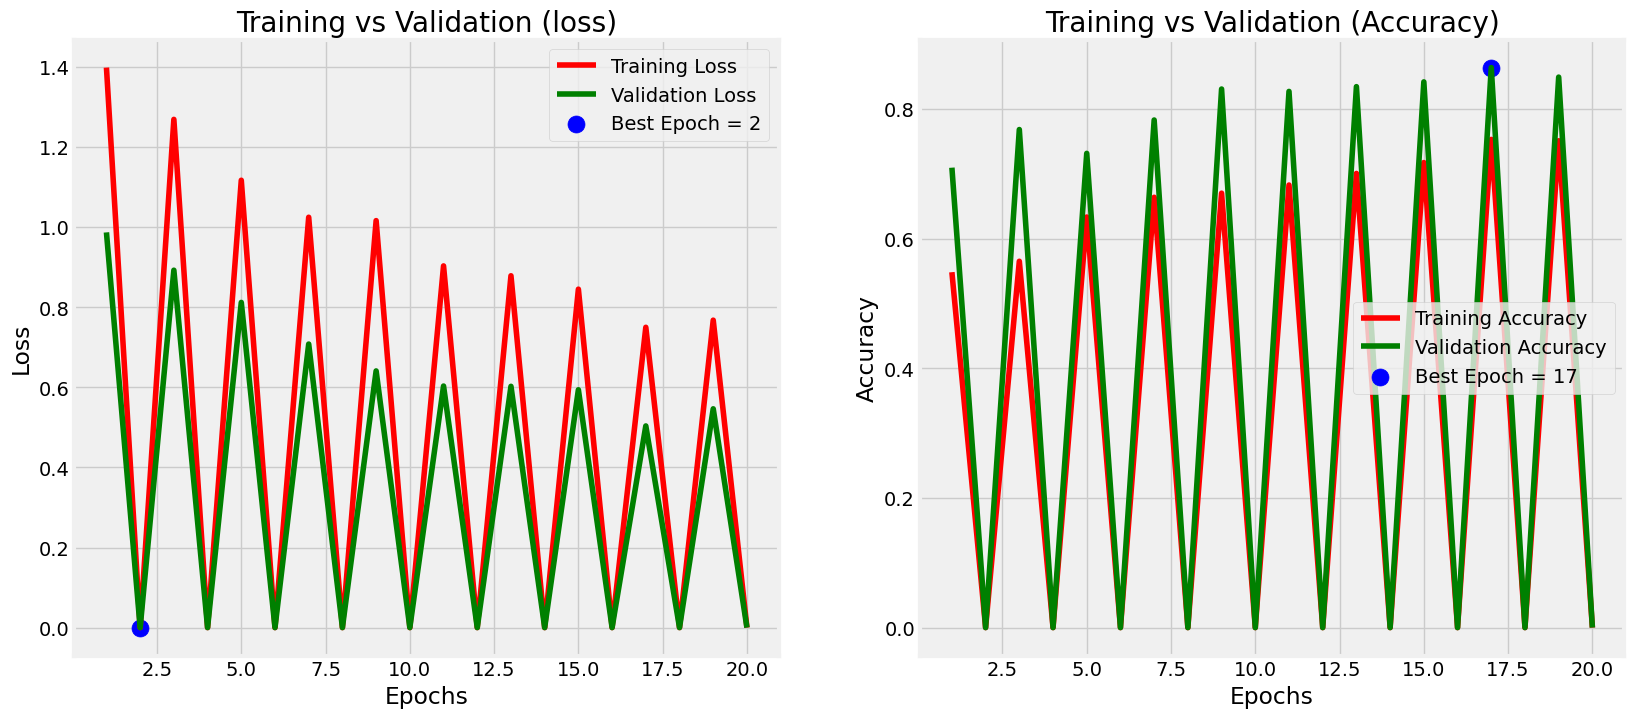

In [16]:
train_acc = H.history['accuracy']
train_loss = H.history['loss']

val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Model Evaluation

In [17]:
from keras.models import load_model
Model_VGG16_fine_tune = load_model('Model_VGG16_fine_tune.h5')

train_score = Model_VGG16_fine_tune.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = Model_VGG16_fine_tune.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = Model_VGG16_fine_tune.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.9224 - loss: 0.2863
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.8608 - loss: 0.5535
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.8664 - loss: 0.4434
Train loss = 0.3325483202934265
Train Accuracy = 0.90234375
Validation loss = 0.5459772348403931
Validation Accuracy = 0.8515625
Test loss = 0.48233020305633545
Test Accuracy = 0.845588207244873


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán
preds = Model_VGG16_fine_tune.predict(test_gen)
preds = np.argmax(preds, axis=1)

# Lấy nhãn thật
true_labels = test_gen.classes

# Tính các chỉ số
report = classification_report(true_labels, preds, output_dict=True)

# In chỉ số f1, precision, recall
print("F1:", report['weighted avg']['f1-score'])
print("Precision:", report['weighted avg']['precision'])
print("Recall:", report['weighted avg']['recall'])

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step
F1: 0.8433237850192867
Precision: 0.8709617180205416
Recall: 0.8455882352941176


In [19]:
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.80      1.00      0.89         8
           2       1.00      0.88      0.93         8
           3       1.00      0.50      0.67         8
           4       0.58      0.88      0.70         8
           5       0.86      0.75      0.80         8
           6       0.89      1.00      0.94         8
           7       1.00      1.00      1.00         8
           8       0.88      0.88      0.88         8
           9       0.80      1.00      0.89         8
          10       1.00      0.88      0.93         8
          11       0.88      0.88      0.88         8
          12       1.00      0.75      0.86         8
          13       1.00      0.88      0.93         8
          14       1.00      0.62      0.77         8
          15       0.57      0.50      0.53         8
          16       0.89      1.00      0.94         8

    accuracy              

## Model Prediction

## Confusion Matrix and Classification Report

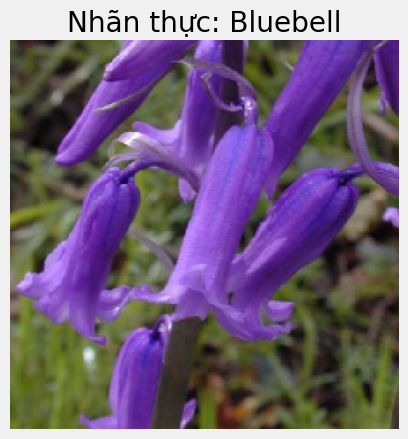

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Dự đoán: Bluebell


In [20]:
# Lấy 1 batch dữ liệu từ generator
batch = next(test_gen)

# In hình ảnh đầu tiên và nhãn tương ứng
img = batch[0][0]
label_index = np.argmax(batch[1][0]) # Lấy index của nhãn cao nhất
label_name = classes[label_index]
plt.imshow(img)
plt.title(f"Nhãn thực: {label_name}") # Hiển thị nhãn thực trên tiêu đề
plt.axis('off')
plt.show()

# Chuyển đổi thành 4D tensor
img = np.expand_dims(img, axis=0)

# Dự đoán
pred = Model_VGG16_fine_tune.predict(img)
print('Dự đoán:', classes[np.argmax(pred)])

In [40]:
# Tính confusion matrix
conf_mat = confusion_matrix(true_labels, preds)

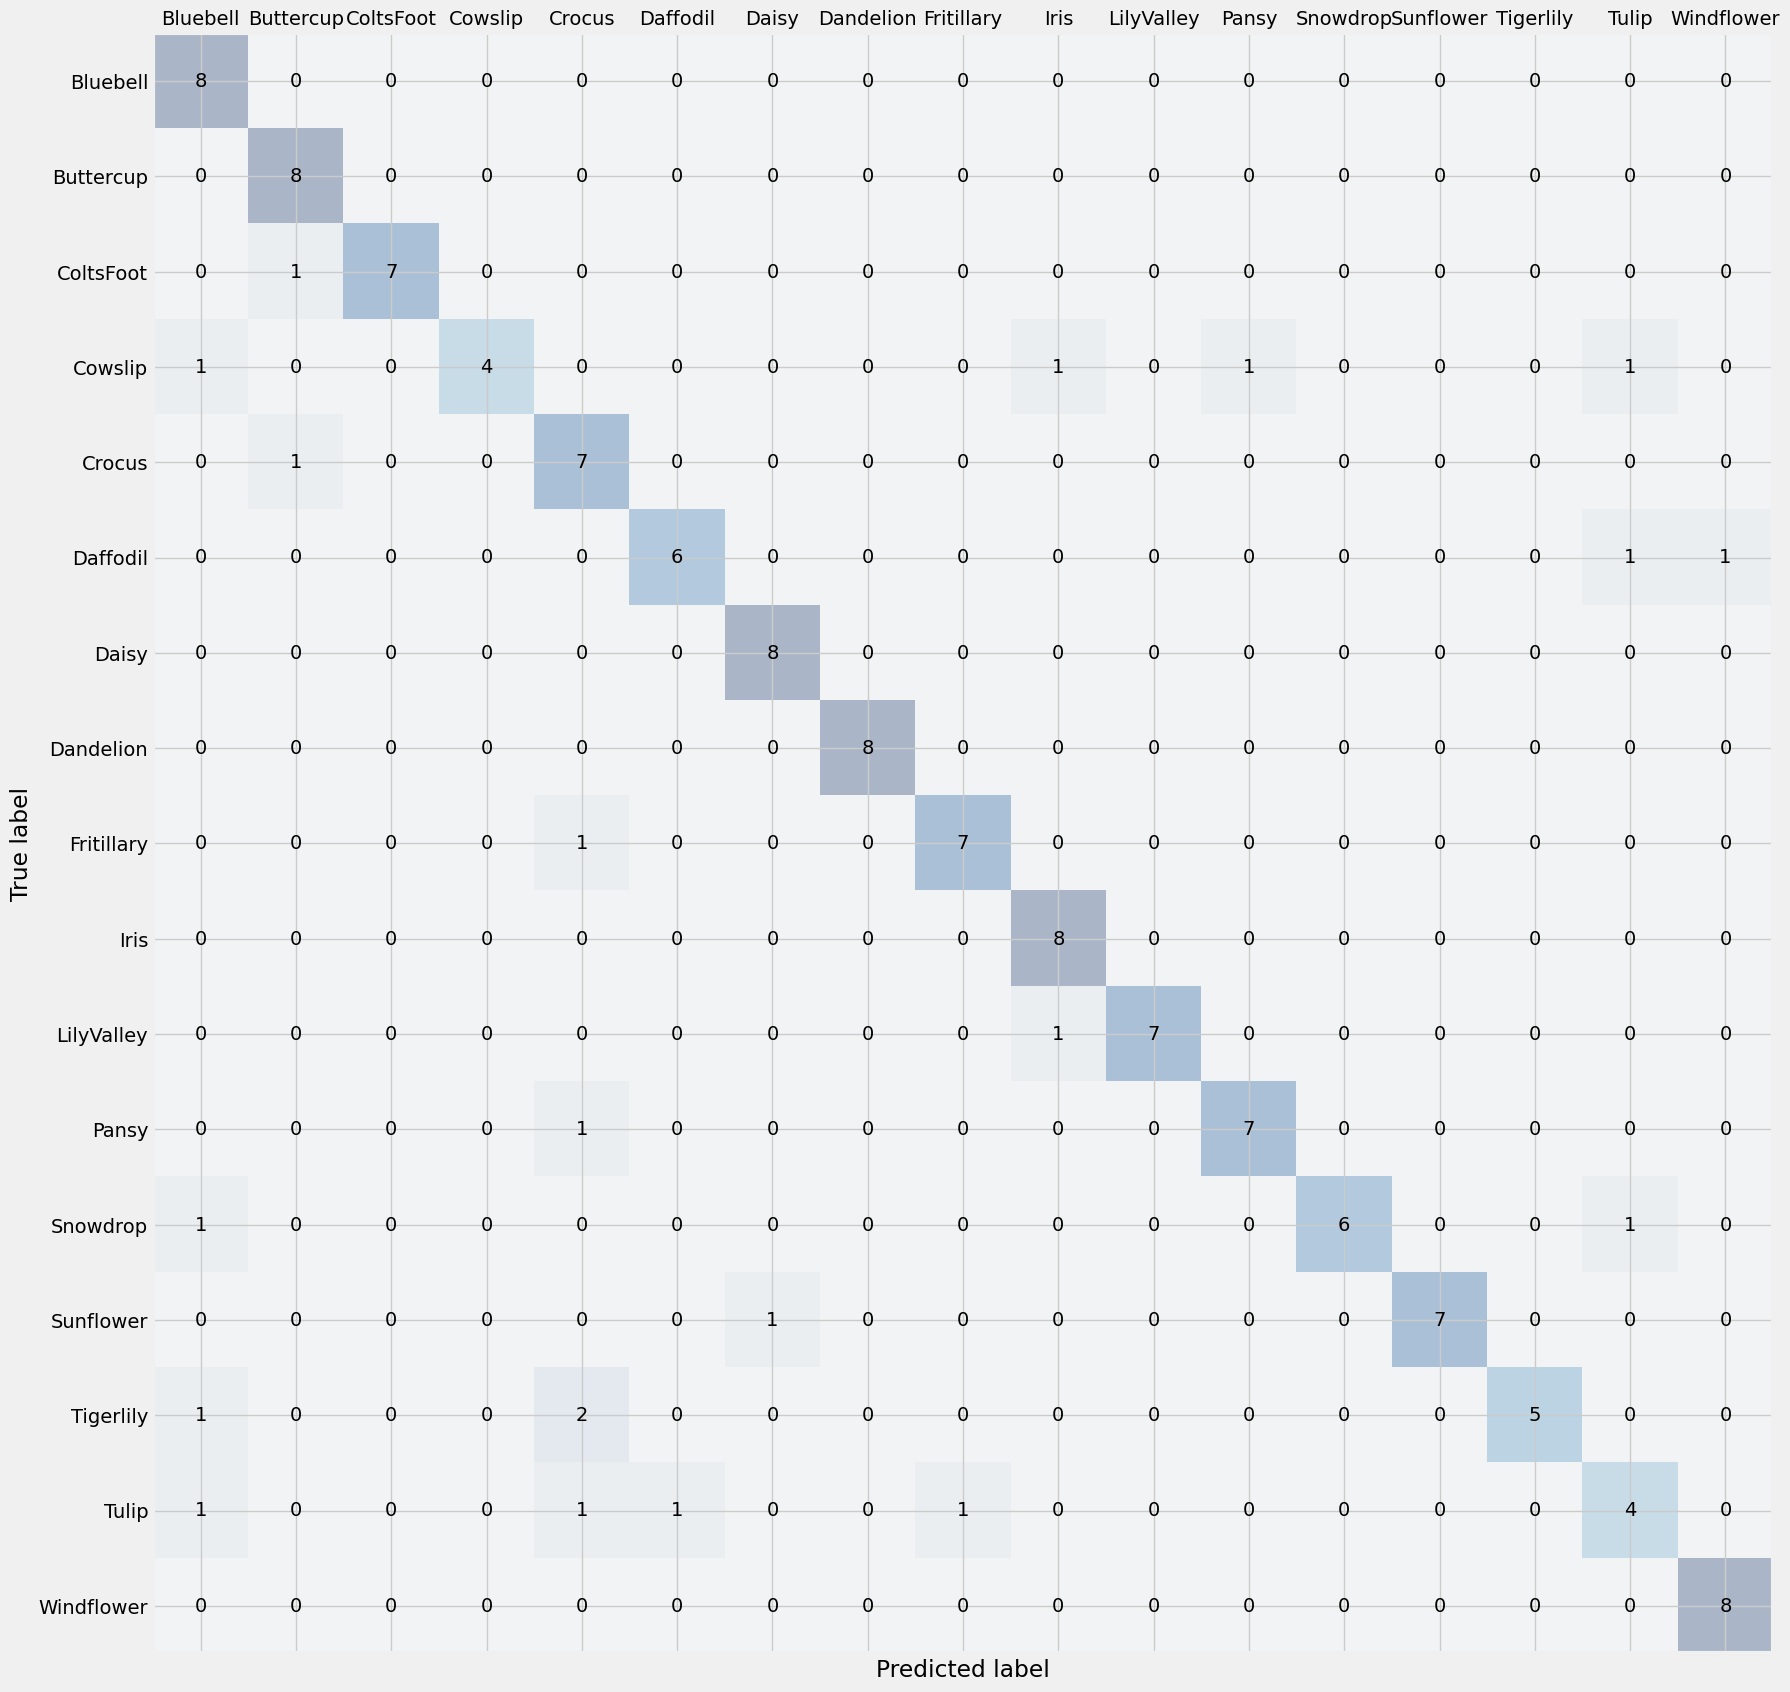

In [41]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)

# Hiển thị các nhãn trên trục Ox và Oy
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Hiển thị giá trị của ma trận nhầm lẫn trong từng ô
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i,j], va='center', ha='center')

# Đặt tiêu đề và nhãn cho trục Ox và Oy
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

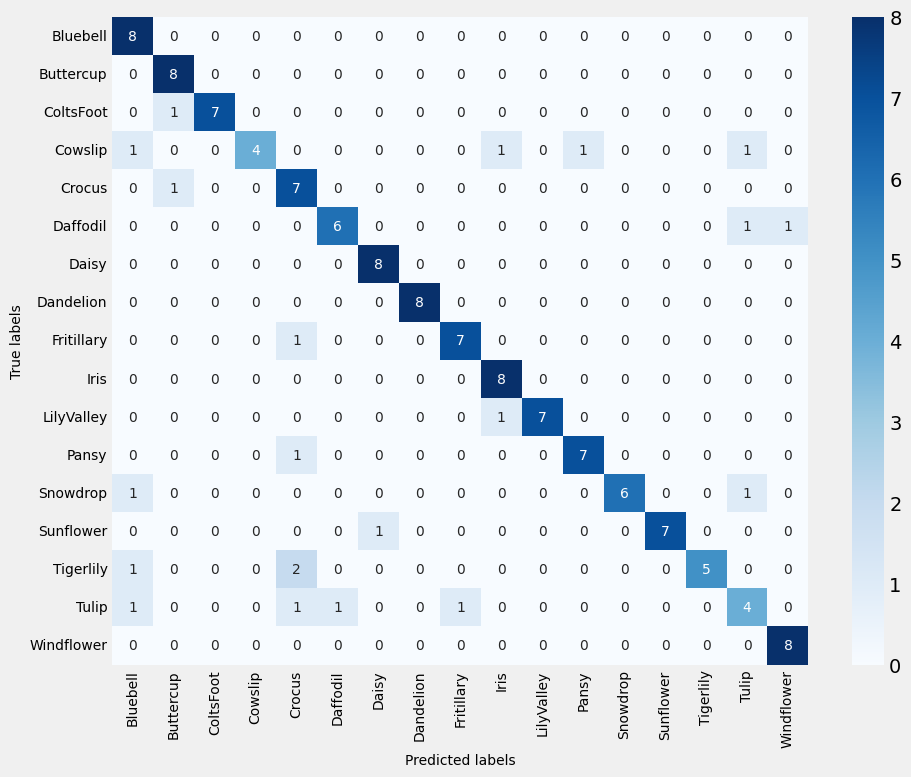

In [67]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(true_labels, preds)

label_encoder = LabelEncoder()
label_encoder.fit(classes)
label_names = label_encoder.inverse_transform(np.unique(true_labels))
sorted_cm = cm[np.argsort(label_names)][:, np.argsort(label_names)]
df_cm = pd.DataFrame(sorted_cm, index=label_names, columns=label_names)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 10})
plt.xlabel('Predicted labels', fontsize=10)
plt.ylabel('True labels', fontsize=10)

# Tùy chỉnh kích thước của font chữ cho các nhãn trên trục x và y
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()